In [1]:
# Imports

import os
import shutil
from random import shuffle
import pandas as pd
import numpy as np
import torchmetrics
from sklearn.metrics import classification_report
import seaborn as sns
import plotly.express as px
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms as T
from torchinfo import summary
import pytorch_lightning as pl
from pytorch_lightning.metrics.classification import Accuracy
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, model_checkpoint

In [2]:
# Getting our images in the right folders so we can use ImageFolder

project_path = os.getcwd().replace('/notebooks', '')
csv_path = project_path + '/data/HAM10000_metadata'
metadata = pd.read_csv(csv_path)

lesion_ids = metadata['lesion_id'].unique()
shuffle(lesion_ids)
lesion_ids = list(lesion_ids)

val_size = 0.15
test_size = 0.15

def set_membership(lesion_id):
    idx = lesion_ids.index(lesion_id)
    if idx < test_size*len(lesion_ids):
        return 'test'
    elif idx < (test_size+val_size)*len(lesion_ids):
        return 'val'
    else:
        return 'train'

for i in ['train', 'val', 'test']:
    path = project_path + '/data/images/' + i
    if not os.path.exists(path):
        os.mkdir(path)

for index, row in metadata.iterrows():
    destination_set = set_membership(row['lesion_id'])
    source = project_path + '/data/images/' + row['image_id'] + '.jpg'
    destination = project_path + '/data/images/' + destination_set + '/' + row['dx'] + '/' + row['image_id'] + '.jpg'
    destination_folder = project_path + '/data/images/' + destination_set + '/' + row['dx']
    if not os.path.exists(destination_folder):
        os.mkdir(destination_folder)
    if os.path.exists(source):
        shutil.move(source, destination)

akiec - Aktinic Keratoses or intraepithelial carcinoma - Cancerous or pre-cancerous


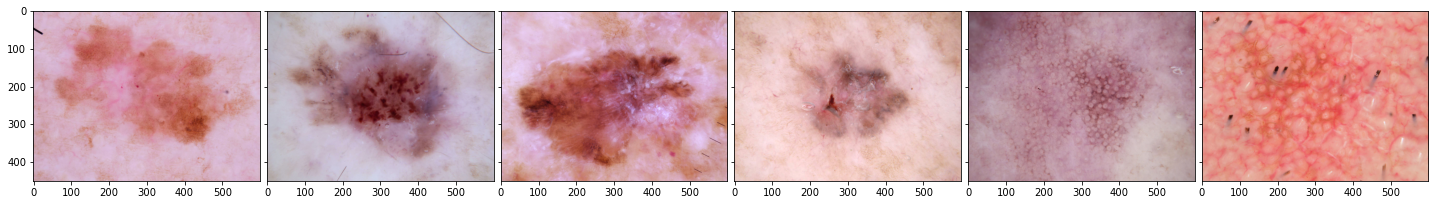

bcc - Basal Cell Carcinoma - Cancerous


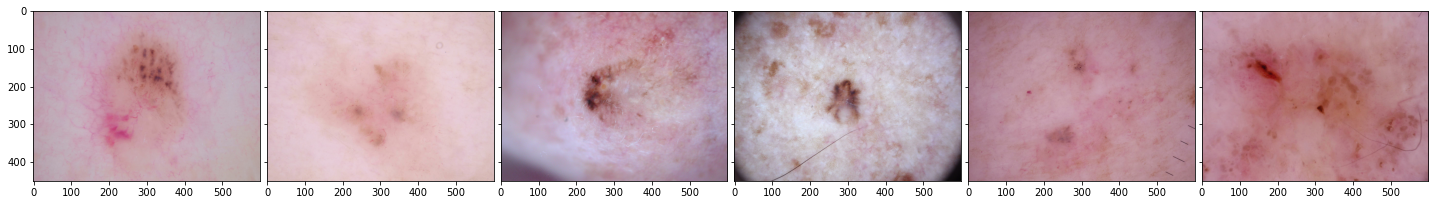

bkl - Benign Keratoses - Benign


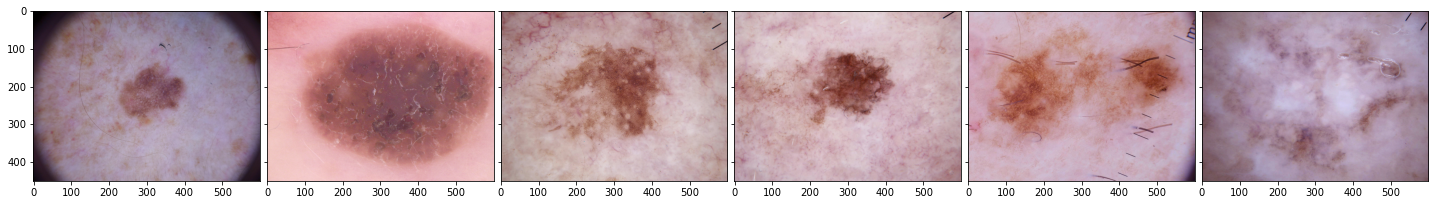

df - Dermatofibroma - Benign


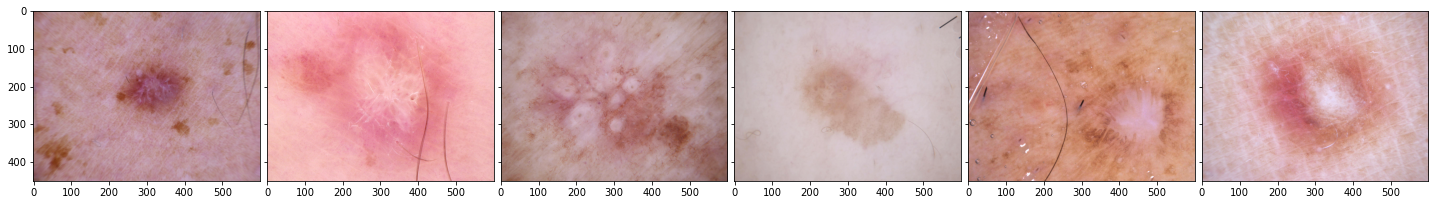

mel - Melanoma - Cancerous


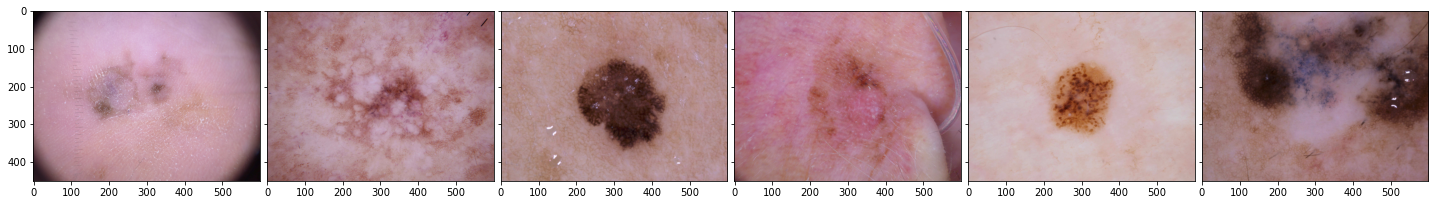

nv - Melanocytic Nevi - Benign


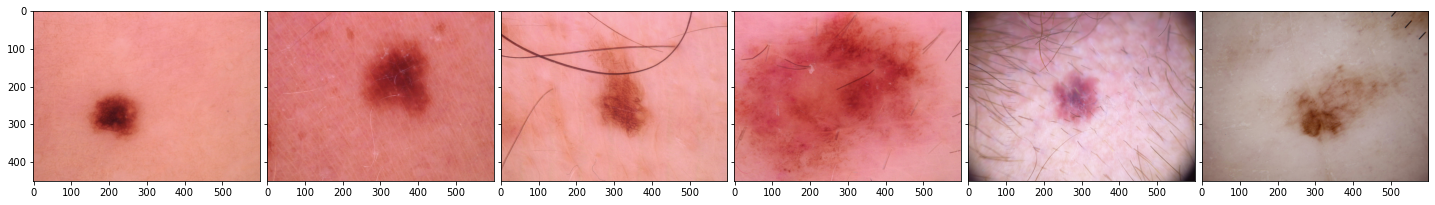

vasc - Vascular Lesions - Benign


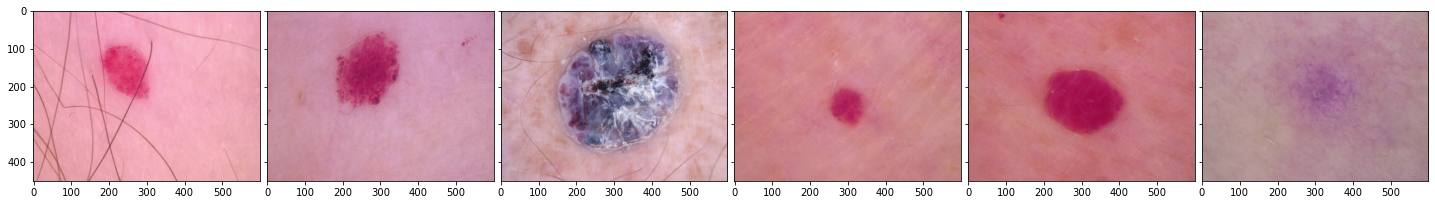

In [3]:
# Show what our data is like

labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
classes = ['Aktinic Keratoses or intraepithelial carcinoma', 'Basal Cell Carcinoma', 'Benign Keratoses', 'Dermatofibroma', 'Melanoma', 'Melanocytic Nevi', 'Vascular Lesions']
cancerous = ['Cancerous or pre-cancerous', 'Cancerous', 'Benign', 'Benign', 'Cancerous', 'Benign', 'Benign']
images_per_class = 6

for label in labels:
    filenames = os.listdir(project_path + '/data/images/train/' + label)[:images_per_class]
    print(f'{label} - {classes[labels.index(label)]} - {cancerous[labels.index(label)]}')
    img_arr = [np.asarray(Image.open(project_path + '/data/images/train/' + label + '/' + filename)) for filename in filenames]
    fig = plt.figure(figsize=(25.0, 10.0))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, images_per_class), axes_pad=0.1)
    for ax, im in zip(grid, img_arr):
        ax.imshow(im)
    plt.show()

In [4]:
# Setting up our dataloaders

labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

def estimate_weights_mfb(labels):
    frequencies = []
    for label in labels:
        count = len(metadata[metadata['dx'] == label]['dx'])
        frequencies.append(count)
    median_freq = np.median(frequencies)
    weights = [median_freq/freq for freq in frequencies]
    return weights

def sampler_weights(dataset, class_weights):
    weights = []
    for img, label in dataset:
        weights.append(class_weights[label])
    return torch.tensor(weights)

train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)), # Size expected by pretrained ResNet50
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ImageNet mean and std dev
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(90),
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)), 
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

batch_size = 64
num_workers = 8
class_weights = estimate_weights_mfb(labels)
train_ds = torchvision.datasets.ImageFolder(project_path + '/data/images/train', transform=train_transform)
val_ds = torchvision.datasets.ImageFolder(project_path + '/data/images/val', transform=test_transform)
test_ds = torchvision.datasets.ImageFolder(project_path + '/data/images/test', transform=test_transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, sampler=WeightedRandomSampler(sampler_weights(train_ds, class_weights), len(train_ds), replacement=True))
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, sampler=WeightedRandomSampler(sampler_weights(val_ds, class_weights), len(val_ds), replacement=True))
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers, sampler=WeightedRandomSampler(sampler_weights(test_ds, class_weights), len(test_ds), replacement=True))

In [5]:
# Architecture specification

class LeNet(pl.LightningModule):
    def __init__(self, lr=1e-3, dropout=0.2):
        super().__init__()
        self.lr = lr
        self.accuracy = Accuracy()

        self.lenet = nn.Sequential(
            nn.Conv2d(3, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(16, 16, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(16, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout*2),
            nn.Flatten(),
            nn.Linear(32*28*28, 512),
            nn.ReLU(),
            nn.Dropout(dropout*2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(dropout*2),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        return self.lenet(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
        }

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self.lenet(x)
        loss = F.cross_entropy(y_pred, y_true)
        acc = self.accuracy(torch.argmax(y_pred, dim=1), y_true)
        self.log('train_loss', loss, prog_bar=False, on_step=False, on_epoch=True)
        self.log('train_accuracy', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self.lenet(x)
        loss = F.cross_entropy(y_pred, y_true)
        acc = self.accuracy(torch.argmax(y_pred, dim=1), y_true)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', acc, prog_bar=True)

In [8]:
# Init model and trainer

logger = CSVLogger("logs", name="LeNetLike", version='1.0')
callbacks = [
    EarlyStopping('val_accuracy', mode='max', patience=2),
    LearningRateMonitor(logging_interval='step'),
    model_checkpoint.ModelCheckpoint(monitor='val_accuracy', mode='max', save_weights_only=True, filename='best_accuracy')
    ]
trainer = pl.Trainer(gpus=1, auto_lr_find=False, max_epochs=50, logger=logger, callbacks=callbacks)
model = LeNet(lr=1e-4)
summary(model, input_size=(batch_size, 3, 224, 224))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    --                        --
├─Sequential: 1-1                        [64, 7]                   --
│    └─Conv2d: 2-1                       [64, 16, 224, 224]        1,216
│    └─ReLU: 2-2                         [64, 16, 224, 224]        --
│    └─MaxPool2d: 2-3                    [64, 16, 112, 112]        --
│    └─Dropout: 2-4                      [64, 16, 112, 112]        --
│    └─Conv2d: 2-5                       [64, 16, 112, 112]        2,320
│    └─ReLU: 2-6                         [64, 16, 112, 112]        --
│    └─MaxPool2d: 2-7                    [64, 16, 56, 56]          --
│    └─Dropout: 2-8                      [64, 16, 56, 56]          --
│    └─Conv2d: 2-9                       [64, 32, 56, 56]          4,640
│    └─ReLU: 2-10                        [64, 32, 56, 56]          --
│    └─MaxPool2d: 2-11                   [64, 32, 28, 28]          --
│    └

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | lenet    | Sequential | 13.1 M
----------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params
52.480    Total estimated model params size (MB)
Finding best initial lr: 100%|██████████| 100/100 [00:28<00:00,  4.64it/s]Restored states from the checkpoint file at /home/ryan/Documents/Springboard/Cancer-Detection-Capstone/notebooks/lr_find_temp_model.ckpt
Learning rate set to 0.0007613548130006165
<ipython-input-7-bedf49aabc6e>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Suggested LR: 0.0007613548130006165


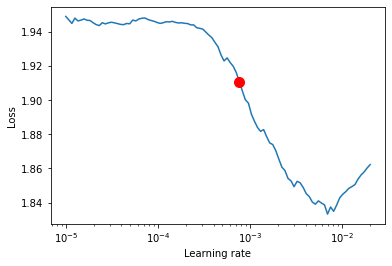

In [7]:
# Optionally use lrfinder

lr_finder = trainer.tuner.lr_find(model, train_loader, val_loader, num_training=100, update_attr=True, min_lr=1e-5, max_lr=2e-2)
print(f'Suggested LR: {lr_finder.suggestion()}')
fig = lr_finder.plot(suggest=True)
fig.show()

In [9]:
# Train

trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory logs/LeNetLike/1.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name     | Type       | Params
----------------------------------------
0 | accuracy | Accuracy   | 0     
1 | lenet    | Sequential | 13.1 M
----------------------------------------
13.1 M    Trainable params
0         Non-trainable params
13.1 M    Total params
52.480    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 134/134 [00:36<00:00,  3.70it/s, loss=1.06, v_num=1.0, val_loss=1.320, val_accuracy=0.484, train_accuracy=0.572]


In [10]:
# Visualize losses/metrics

log_dir = project_path + '/notebooks/logs/LeNetLike/1.0/'
log = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))

train_log = log[['step', 'train_loss']].dropna().rename(columns={'train_loss': 'loss'})
train_log['set'] = 'train'
val_log = log[['step', 'val_loss']].dropna().rename(columns={'val_loss': 'loss'})
val_log['set'] = 'val'

log = train_log.append(val_log)
log = log.sort_values(by=['step'])

fig = px.line(log, x='step', y='loss', color='set')
fig.show()

log = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))

train_log = log[['step', 'train_accuracy']].dropna().rename(columns={'train_accuracy': 'accuracy'})
train_log['set'] = 'train'
val_log = log[['step', 'val_accuracy']].dropna().rename(columns={'val_accuracy': 'accuracy'})
val_log['set'] = 'val'

log = train_log.append(val_log)
log = log.sort_values(by=['step'])

fig = px.line(log, x='step', y='accuracy', color='set')
fig.show()

Finding best initial lr: 100%|██████████| 100/100 [09:45<00:00,  5.85s/it]


In [ ]:
# Load a model we want to check out.

path = project_path + '/models/LeNetLike.pth'
#model.load_state_dict(torch.load(path))

In [11]:
# Load best model from training

path = project_path + '/notebooks/logs/LeNetLike/1.0/checkpoints/best_accuracy.ckpt'
model = LeNet.load_from_checkpoint(path)

              precision    recall  f1-score   support

       akiec       0.44      0.31      0.36       171
         bcc       0.36      0.54      0.43       203
         bkl       0.51      0.42      0.46       262
          df       0.52      0.32      0.39       317
         mel       0.39      0.66      0.49       176
          nv       0.66      0.55      0.60       200
        vasc       0.63      0.74      0.68       186

    accuracy                           0.49      1515
   macro avg       0.50      0.50      0.49      1515
weighted avg       0.51      0.49      0.48      1515



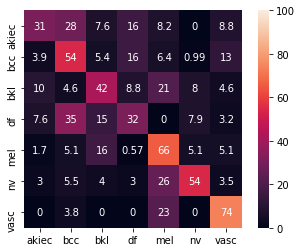

In [13]:
# Confusion matrix

confmat = torchmetrics.ConfusionMatrix(num_classes=7, normalize='true')
model.eval()
y_preds = []
y_trues = []
with torch.no_grad():
        for x, y_true in val_loader:
                y_pred = F.softmax(model(x), dim=1)
                confmat(y_pred, y_true)
                y_preds.extend(torch.max(y_pred, 1)[1].tolist())
                y_trues.extend(y_true.tolist())

classes = ('akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc')
sns.heatmap(confmat.compute()*100.0, annot=True, square=True, vmin=0.0, vmax=100.0, xticklabels=classes, yticklabels=classes)
print(classification_report(y_trues, y_preds, target_names=classes))

In [12]:
# Save the model if we like it.

path = project_path + '/models/LeNetLike.pth'
#torch.save(model.state_dict(), path)

In [14]:
# ResNet time

class ResNet(pl.LightningModule):
    def __init__(self, lr=1e-3, freeze=True, dropout=0.5):
        super().__init__()
        self.lr = lr
        self.accuracy = Accuracy()

        self.resnet = torchvision.models.resnet50(pretrained=True)
        if freeze:
            for param in self.resnet.parameters():
                param.requires_grad = False
            for param in self.resnet.layer1.parameters():
                param.requires_grad = False
            for param in self.resnet.layer2.parameters():
                param.requires_grad = False
            for param in self.resnet.layer3.parameters():
                param.requires_grad = True
            for param in self.resnet.layer4.parameters():
                param.requires_grad = True
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(2048, 7),
        )

    def forward(self, x):
        return self.resnet(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler,
           'monitor': 'val_loss'
        }

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self.resnet(x)
        loss = F.cross_entropy(y_pred, y_true)
        acc = self.accuracy(F.softmax(y_pred, dim=1), y_true)
        self.log('train_loss', loss, prog_bar=False, on_step=False, on_epoch=True)
        self.log('train_accuracy', acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_pred = self.resnet(x)
        loss = F.cross_entropy(y_pred, y_true)
        acc = self.accuracy(F.softmax(y_pred, dim=1), y_true)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_accuracy', acc, prog_bar=True)

In [17]:
# Init model and trainer

logger = CSVLogger("logs", name="ResNet", version='1.0')
callbacks = [
    EarlyStopping('val_accuracy', mode='max', patience=3),
    LearningRateMonitor(logging_interval='step'),
    model_checkpoint.ModelCheckpoint(monitor='val_accuracy', mode='max', save_weights_only=True, filename='best_accuracy')
    ]
trainer = pl.Trainer(gpus=1, auto_lr_find=False, max_epochs=50, logger=logger, callbacks=callbacks, log_every_n_steps=100)
model = ResNet(lr=1e-5, freeze=True)
summary(model, input_size=(batch_size, 3, 224, 224), depth=2)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        --                        --
├─ResNet: 1-1                                 [64, 7]                   --
│    └─Conv2d: 2-1                            [64, 64, 112, 112]        (9,408)
│    └─BatchNorm2d: 2-2                       [64, 64, 112, 112]        (128)
│    └─ReLU: 2-3                              [64, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [64, 64, 56, 56]          --
│    └─Sequential: 2-5                        [64, 256, 56, 56]         (215,808)
│    └─Sequential: 2-6                        [64, 512, 28, 28]         (1,219,584)
│    └─Sequential: 2-7                        [64, 1024, 14, 14]        7,098,368
│    └─Sequential: 2-8                        [64, 2048, 7, 7]          14,964,736
│    └─AdaptiveAvgPool2d: 2-9                 [64, 2048, 1, 1]          --
│    └─Sequential: 2-10                       [64, 7]   

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | accuracy | Accuracy | 0     
1 | resnet   | ResNet   | 23.5 M
--------------------------------------
22.1 M    Trainable params
1.4 M     Non-trainable params
23.5 M    Total params
94.090    Total estimated model params size (MB)
Finding best initial lr: 100%|██████████| 100/100 [00:56<00:00,  1.81it/s]Restored states from the checkpoint file at /home/ryan/Documents/Springboard/Cancer-Detection-Capstone/notebooks/lr_find_temp_model.ckpt
Learning rate set to 0.0001737800828749376
Finding best initial lr: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s]
<ipython-input-16-4fb5e2e23ce6>:6: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



Suggested LR: 0.0001737800828749376


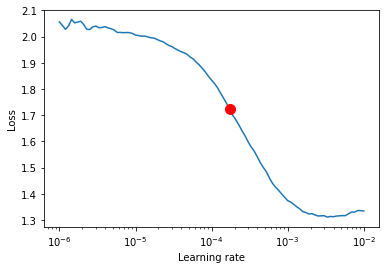

In [16]:
# Optionally use lrfinder

lr_finder = trainer.tuner.lr_find(model, train_loader, val_loader, num_training=100, update_attr=True, min_lr=1e-6, max_lr=1e-2)
print(f'Suggested LR: {lr_finder.suggestion()}')
fig = lr_finder.plot(suggest=True)
fig.show()

In [18]:
# Train

trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ryan/anaconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning:

Experiment logs directory logs/ResNet/1.0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!


  | Name     | Type     | Params
--------------------------------------
0 | accuracy | Accuracy | 0     
1 | resnet   | ResNet   | 23.5 M
--------------------------------------
22.1 M    Trainable params
1.4 M     Non-trainable params
23.5 M    Total params
94.090    Total estimated model params size (MB)


Epoch 14: 100%|██████████| 134/134 [01:22<00:00,  1.62it/s, loss=0.287, v_num=1.0, val_loss=0.773, val_accuracy=0.725, train_accuracy=0.901]


In [19]:
# Visualize losses/metrics

log_dir = project_path + '/notebooks/logs/ResNet/1.0/'
log = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))

train_log = log[['step', 'train_loss']].dropna().rename(columns={'train_loss': 'loss'})
train_log['set'] = 'train'
val_log = log[['step', 'val_loss']].dropna().rename(columns={'val_loss': 'loss'})
val_log['set'] = 'val'

log = train_log.append(val_log)
log = log.sort_values(by=['step'])

fig = px.line(log, x='step', y='loss', color='set')
fig.show()

log = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))

train_log = log[['step', 'train_accuracy']].dropna().rename(columns={'train_accuracy': 'accuracy'})
train_log['set'] = 'train'
val_log = log[['step', 'val_accuracy']].dropna().rename(columns={'val_accuracy': 'accuracy'})
val_log['set'] = 'val'

log = train_log.append(val_log)
log = log.sort_values(by=['step'])

fig = px.line(log, x='step', y='accuracy', color='set')
fig.show()

In [ ]:
# Load a model we want to check out.

path = project_path + '/models/ResNet.pth'
#model.load_state_dict(torch.load(path))

In [20]:
# Load best model from training

path = project_path + '/notebooks/logs/ResNet/1.0/checkpoints/best_accuracy.ckpt'
model = ResNet.load_from_checkpoint(path)

              precision    recall  f1-score   support

       akiec       0.71      0.69      0.70       174
         bcc       0.65      0.90      0.76       217
         bkl       0.76      0.71      0.73       233
          df       0.97      0.63      0.76       305
         mel       0.65      0.62      0.63       182
          nv       0.59      0.81      0.68       192
        vasc       0.97      0.87      0.92       212

    accuracy                           0.74      1515
   macro avg       0.76      0.75      0.74      1515
weighted avg       0.78      0.74      0.75      1515



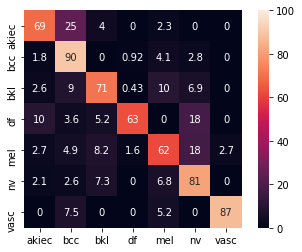

In [22]:
# Confusion matrix

confmat = torchmetrics.ConfusionMatrix(num_classes=7, normalize='true')
model.eval()
y_preds = []
y_trues = []
with torch.no_grad():
        for x, y_true in val_loader:
                y_pred = F.softmax(model(x), dim=1)
                confmat(y_pred, y_true)
                y_preds.extend(torch.max(y_pred, 1)[1].tolist())
                y_trues.extend(y_true.tolist())

classes = ('akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc')
sns.heatmap(confmat.compute()*100.0, annot=True, square=True, vmin=0.0, vmax=100.0, xticklabels=classes, yticklabels=classes)
print(classification_report(y_trues, y_preds, target_names=classes))

In [21]:
# Save the model if we like it.

path = project_path + '/models/ResNet.pth'
#torch.save(model.state_dict(), path)

              precision    recall  f1-score   support

       akiec       0.84      0.63      0.72       300
         bcc       0.63      0.84      0.72       152
         bkl       0.58      0.61      0.59       208
          df       0.92      0.87      0.89       208
         mel       0.63      0.57      0.60       192
          nv       0.68      0.84      0.75       189
        vasc       0.97      0.96      0.96       262

    accuracy                           0.76      1511
   macro avg       0.75      0.76      0.75      1511
weighted avg       0.77      0.76      0.76      1511



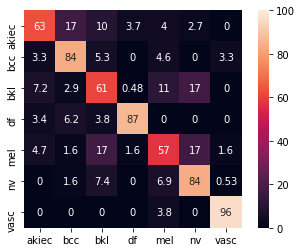

In [23]:
# Evaluate on test set

confmat = torchmetrics.ConfusionMatrix(num_classes=7, normalize='true')
model.eval()
y_preds = []
y_trues = []
with torch.no_grad():
        for x, y_true in test_loader:
                y_pred = F.softmax(model(x), dim=1)
                confmat(y_pred, y_true)
                y_preds.extend(torch.max(y_pred, 1)[1].tolist())
                y_trues.extend(y_true.tolist())

classes = ('akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc')
sns.heatmap(confmat.compute()*100.0, annot=True, square=True, vmin=0.0, vmax=100.0, xticklabels=classes, yticklabels=classes)
print(classification_report(y_trues, y_preds, target_names=classes))